In [37]:
import pandas as pd

file_path = "Data/TRAIN/merged_cleaned_train_data.csv"

df = pd.read_csv(file_path)

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print("Loaded OK:", df.shape)
df.head()


Loaded OK: (93744, 11)


,country,brand_name,month,months_postgx,volume,n_gxs,ther_area,hospital_rate,main_package,biological,small_molecule
0,COUNTRY_B6AE,BRAND_1C1E,Jul,-24,272594.3921,0,Muscoskeletal_Rheumatology_and_Osteology,0.002088,PILL,False,True
1,COUNTRY_B6AE,BRAND_1C1E,Aug,-23,351859.3103,0,Muscoskeletal_Rheumatology_and_Osteology,0.002088,PILL,False,True
2,COUNTRY_B6AE,BRAND_1C1E,Sep,-22,447953.4813,0,Muscoskeletal_Rheumatology_and_Osteology,0.002088,PILL,False,True
3,COUNTRY_B6AE,BRAND_1C1E,Oct,-21,411543.2924,0,Muscoskeletal_Rheumatology_and_Osteology,0.002088,PILL,False,True
4,COUNTRY_B6AE,BRAND_1C1E,Nov,-20,774594.4542,0,Muscoskeletal_Rheumatology_and_Osteology,0.002088,PILL,False,True


Import Libraries

In [40]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputRegressor


Best parameters (Taken by randomsearchCV)

In [43]:
FINAL_XGB_PARAMS = { # needs higher n_estimators to find subtle patterns and avoid underfitting
    'n_estimators': 2000, # need to be higher like 2000
    'learning_rate': 0.01,
    'max_depth': 4,
    'min_child_weight': 10,
    'subsample': 0.6,
    'colsample_bytree': 0.7,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror',
    'reg_lambda': 6.0, #FIXME
}


# separated parameter for s2
FINAL_XGB_PARAMS_s2 = { #converges quickly due to the highly predictive features so needs lower n_estimators to prevent overfitting
    'n_estimators': 600, #  400-600 would be good
    'learning_rate': 0.04, # thinking of changing this to a lower value
    'max_depth': 4,
    'min_child_weight': 10,
    'subsample': 0.6,
    'colsample_bytree': 0.7,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror',
    'reg_lambda': 6.0, #FIXME
}

Path files and keywords

In [46]:
DRIVE_TRAIN_PATH = 'Data/TRAIN/merged_cleaned_train_data.csv'
TEST_FILE_NAME = 'Data/TEST/novartis_test_data_merged_full(new).csv'
KEYS_STATIC = ['country', 'brand_name']
static_cols = ['ther_area', 'main_package', 'biological', 'small_molecule', 'hospital_rate']

In [48]:
# helper functions
def log_transform(df): return np.log1p(df) # shrinks high volume data and stretches the small ones to make the data easier to learn from
def inverse_transform(arr): return np.expm1(arr) # bias correction when predictions were too low

# load data and prep
df = pd.read_csv(DRIVE_TRAIN_PATH)

#drops any redundant columns
if 'Unnamed: 0' in df.columns: df = df.drop(columns=['Unnamed: 0'])
# replaces missing values with mean value to preserve row while maintaining the overall distribution of the variable
df['hospital_rate'] = df['hospital_rate'].fillna(df['hospital_rate'].mean())

# feature engineering
df_pre = df[(df['months_postgx'] >= -12) & (df['months_postgx'] <= -1)] # uses 12 months immediately preceding generic entry
avg_j = df_pre.groupby(KEYS_STATIC)['volume'].mean().reset_index(name='Avg_j') # used because PE is defined as the mean of the last 12 months before generic entry
df_static = df.drop_duplicates(subset=KEYS_STATIC)[KEYS_STATIC + static_cols]
X_base = pd.merge(df_static, avg_j, on=KEYS_STATIC, how='inner').set_index(KEYS_STATIC) #for scenario 1 prediction (uninformed features)

# X1, Y1 (M0..M23)
df_Y1 = df[(df['months_postgx'] >= 0) & (df['months_postgx'] <= 23)] #filters raw data to only include 24 months after generic entry
Y1 = df_Y1.pivot_table(index=KEYS_STATIC, columns='months_postgx', values='volume').fillna(np.nan) # target matrix for y1
X1 = pd.merge(X_base, Y1, left_index=True, right_index=True, how='inner').iloc[:, :-24]
Y1 = Y1.loc[X1.index] # created final target natrix

# X2, Y2 (M6..M23 with M0-M5 features) - Scenario 2 (Informed)

# feature engineering for scenario 2
df_M0_M5 = df[(df['months_postgx'] >= 0) & (df['months_postgx'] <= 5)].pivot_table(index=KEYS_STATIC, columns='months_postgx', values='volume').fillna(np.nan) # filters data to isolate actual volumes
M0_M5_feats = pd.concat([df_M0_M5[0].rename('Vol_M0'), df_M0_M5[5].rename('Vol_M5'), (df_M0_M5[0] - df_M0_M5[5]).rename('Erosion_M0_M5')], axis=1) # calculates initial erosion features months 0-6 post entry volume
X2 = pd.merge(X_base, M0_M5_feats, left_index=True, right_index=True, how='inner') # includes all input information necessary for the informed forecast from month 6 onwards

df_Y2 = df[(df['months_postgx'] >= 6) & (df['months_postgx'] <= 23)] # 18 month prediction
Y2 = df_Y2.pivot_table(index=KEYS_STATIC, columns='months_postgx', values='volume').fillna(np.nan)
Y2 = Y2.loc[X2.index] # created final target matrix

# encoding to prep data for XGBoost
X1['country_feat'] = X1.index.get_level_values('country')
X2['country_feat'] = X2.index.get_level_values('country')
cat_cols = X1.select_dtypes(include=['object']).columns.tolist()
preprocessor = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)], remainder='passthrough') # applied one hot encoding to use XGBoost efficiently
# fit and transform( maximizing data utilization)
X1_enc = preprocessor.fit_transform(X1).astype(float)
X2_enc = preprocessor.transform(X2).astype(float)

# Full Data Buckets (for training weights)
Y1_norm = Y1.div(X_base['Avg_j'], axis=0) # calculate normalized volume
buckets = np.where(Y1_norm.mean(axis=1) <= 0.25, 1, 2) # if bucket labelled 1 = high erosion
weights_full = np.where(buckets == 1, 2.0, 1.0) # this forces model to treat high erosion drugs error twice as costly


# Model Training
print("\n training on full dataset")
Y1_log = log_transform(Y1)
Y2_log = log_transform(Y2)

# Model 1 (S1)
m1 = MultiOutputRegressor(xgb.XGBRegressor(**FINAL_XGB_PARAMS))
m1.fit(X1_enc, Y1_log.values, sample_weight=weights_full)

# Model 2 (S2)
m2 = MultiOutputRegressor(xgb.XGBRegressor(**FINAL_XGB_PARAMS_s2))
m2.fit(X2_enc, Y2_log.values, sample_weight=weights_full)
print("Final Tuned Models Trained Successfully.")


 training on full dataset
Final Tuned Models Trained Successfully.


### Learning curves

In [22]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# leasrning curve func
def plot_learning_curve_single_output(model, X, y, title="Learning Curve", cv=5, scoring="neg_mean_absolute_error"):
    plt.figure(figsize=(10,6))

    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 8),
        shuffle=True,
        random_state=42,
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    val_std  = np.std(val_scores, axis=1)

    plt.plot(train_sizes, train_mean, label="Training score")
    plt.plot(train_sizes, val_mean, label="Validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Score (MAE, neg)")
    plt.legend()
    plt.grid(True)
    plt.show()

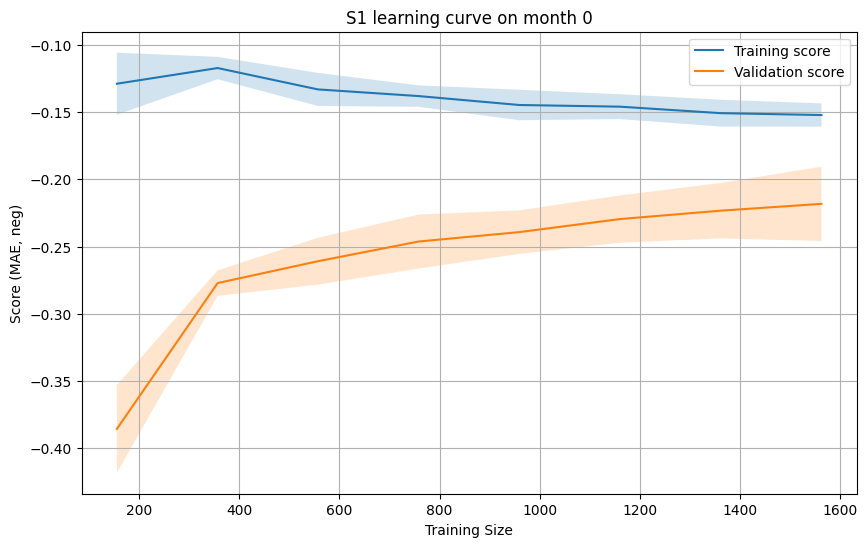

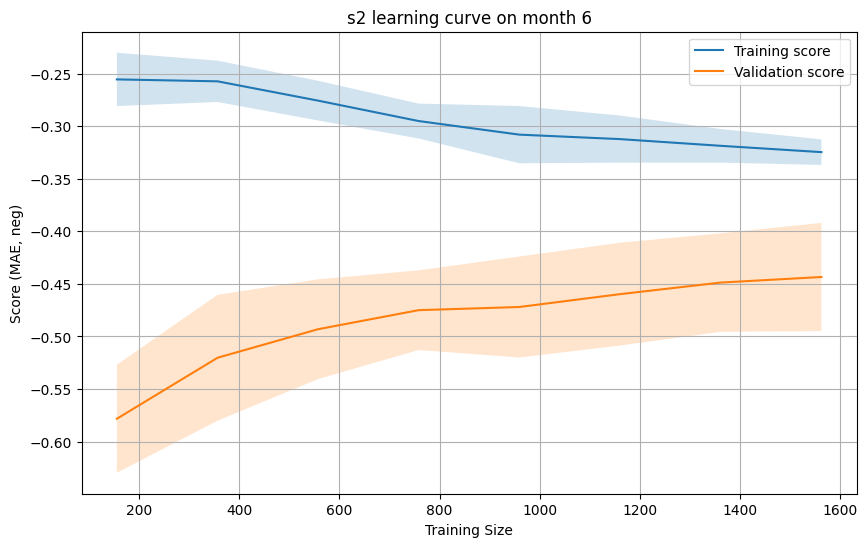

In [24]:
# SCENARIO 1
# inspecting the first month which is month 0 in scenario 1 (since can only plot a single month for learning curve)
y_s1 = Y1_log.values[:, 0]

base_model_s1 = xgb.XGBRegressor(**FINAL_XGB_PARAMS)

plot_learning_curve_single_output(
    base_model_s1,
    X1_enc,
    y_s1,
    title="S1 learning curve on month 0"
)

# SCENARIO 2
# plottin gonly month 6 
y_s2 = Y2_log.values[:, 0]

base_model_s2 = xgb.XGBRegressor(**FINAL_XGB_PARAMS_s2)

plot_learning_curve_single_output(
    base_model_s2,
    X2_enc,
    y_s2,
    title="s2 learning curve on month 6"
)

In [50]:
TEST_FILE_NAME = "Data/TEST/novartis_test_data_merged_full(New).csv"

# Submission CSV
try:
    df_test = pd.read_csv(TEST_FILE_NAME)
except FileNotFoundError:
    print(f"Error: '{TEST_FILE_NAME}' not found.")
    raise

# initial cleaning (Test)
df_test['n_gxs'] = df_test['n_gxs'].fillna(0.0)
df_test['hospital_rate'] = df_test['hospital_rate'].fillna(df_test['hospital_rate'].mean())

# test Feature Engineering (perfectly match train FE)
df_pre_t = df_test[(df_test['months_postgx'] >= -12) & (df_test['months_postgx'] <= -1)]
avg_j_t = df_pre_t.groupby(KEYS_STATIC)['volume'].mean().reset_index(name='Avg_j')
df_static_t = df_test.drop_duplicates(subset=KEYS_STATIC)[KEYS_STATIC + static_cols]
X_base_t = pd.merge(df_static_t, avg_j_t, on=KEYS_STATIC, how='inner').set_index(KEYS_STATIC)
df_M0_M5_t = df_test[(df_test['months_postgx'] >= 0) & (df_test['months_postgx'] <= 5)].pivot_table(index=KEYS_STATIC, columns='months_postgx', values='volume').fillna(np.nan)
M0_M5_feats_t = pd.concat([df_M0_M5_t[0].rename('Vol_M0'), df_M0_M5_t[5].rename('Vol_M5'), (df_M0_M5_t[0] - df_M0_M5_t[5]).rename('Erosion_M0_M5')], axis=1)

# split Test drugs
s2_drugs = M0_M5_feats_t.dropna().index
s1_drugs = X_base_t.index.difference(s2_drugs)

# prepare final prediction matrices
X_test_S1 = X_base_t.loc[s1_drugs].copy()
X_test_S1['country_feat'] = X_test_S1.index.get_level_values('country')
X_test_S2 = pd.merge(X_base_t, M0_M5_feats_t, left_index=True, right_index=True, how='inner').loc[s2_drugs]
X_test_S2['country_feat'] = X_test_S2.index.get_level_values('country')

# encoding
X_test_S1_enc = preprocessor.transform(X_test_S1).astype(float)
X_test_S2_enc = preprocessor.transform(X_test_S2).astype(float)

# predict
p_s1_log = m1.predict(X_test_S1_enc)
p_s2_log = m2.predict(X_test_S2_enc)

p_s1_final = np.maximum(0, inverse_transform(p_s1_log))
p_s2_final = np.maximum(0, inverse_transform(p_s2_log))

# Combine and Save
df_p1 = pd.DataFrame(p_s1_final, index=X_test_S1.index, columns=[f'Volume_M{i}' for i in range(24)])
df_p2 = pd.DataFrame(p_s2_final, index=X_test_S2.index, columns=[f'Volume_M{i}' for i in range(6, 24)])

p1_long = df_p1.stack().reset_index()
p1_long.columns = ['country', 'brand_name', 'm_col', 'volume']
p1_long['months_postgx'] = p1_long['m_col'].str.replace('Volume_M', '').astype(int)

p2_long = df_p2.stack().reset_index()
p2_long.columns = ['country', 'brand_name', 'm_col', 'volume']
p2_long['months_postgx'] = p2_long['m_col'].str.replace('Volume_M', '').astype(int)

final_submission = pd.concat([p1_long[['country', 'brand_name', 'months_postgx', 'volume']], p2_long[['country', 'brand_name', 'months_postgx', 'volume']]])

filename = 'final.csv'
final_submission.to_csv(filename, index=False)
# files.download(filename)
print(f"Submission Complete! Final CSV '{filename}' created with {len(final_submission)} rows.")

Submission Complete! Final CSV 'final.csv' created with 7488 rows.


Metrics calculation (From Novartis)

In [30]:
import pandas as pd
import numpy as np

# successfully defined:
# X1_val, Y1_val, X2_val, Y2_val (Validation feature/target sets)
# m1, m2 (Trained XGBoost models)
# df_aux_val (Auxiliary data with bucket/avg_vol)
# log_transform, inverse_transform (Helper functions)

def _compute_pe_phase1a(group: pd.DataFrame) -> float:

    avg_vol = group["avg_vol"].iloc[0];
    if avg_vol == 0 or np.isnan(avg_vol): return np.nan
    def sum_abs_diff(month_start: int, month_end: int) -> float:
        subset = group[(group["months_postgx"] >= month_start) & (group["months_postgx"] <= month_end)];
        return (subset["volume_actual"] - subset["volume_predict"]).abs().sum()
    def abs_sum_diff(month_start: int, month_end: int) -> float:
        subset = group[(group["months_postgx"] >= month_start) & (group["months_postgx"] <= month_end)];
        return abs(subset["volume_actual"].sum() - subset["volume_predict"].sum())
    term1 = 0.2 * sum_abs_diff(0, 23) / (24 * avg_vol);
    term2 = 0.5 * abs_sum_diff(0, 5) / (6 * avg_vol);
    term3 = 0.2 * abs_sum_diff(6, 11) / (6 * avg_vol);
    term4 = 0.1 * abs_sum_diff(12, 23) / (12 * avg_vol);
    return term1 + term2 + term3 + term4

def compute_metric1(df_actual: pd.DataFrame, df_pred: pd.DataFrame, df_aux: pd.DataFrame) -> float:

    merged = df_actual.merge(df_pred, on=["country", "brand_name", "months_postgx"], how="inner", suffixes=("_actual", "_predict")).merge(df_aux, on=["country", "brand_name"], how="left");
    merged["start_month"] = merged.groupby(["country", "brand_name"])["months_postgx"].transform("min");
    merged = merged[merged["start_month"] == 0].copy();
    pe_results = (merged.groupby(["country", "brand_name", "bucket"]).apply(_compute_pe_phase1a).reset_index(name="PE"));
    bucket1 = pe_results[pe_results["bucket"] == 1]; bucket2 = pe_results[pe_results["bucket"] == 2];
    n1 = len(bucket1); n2 = len(bucket2); score = 0;
    if n1 > 0: score += (2 / n1) * bucket1["PE"].sum();
    if n2 > 0: score += (1 / n2) * bucket2["PE"].sum();
    return round(score, 4)

def _compute_pe_phase1b(group: pd.DataFrame) -> float:

    avg_vol = group["avg_vol"].iloc[0];
    if avg_vol == 0 or np.isnan(avg_vol): return np.nan
    def sum_abs_diff(month_start: int, month_end: int) -> float:
        subset = group[(group["months_postgx"] >= month_start) & (group["months_postgx"] <= month_end)];
        return (subset["volume_actual"] - subset["volume_predict"]).abs().sum()
    def abs_sum_diff(month_start: int, month_end: int) -> float:
        subset = group[(group["months_postgx"] >= month_start) & (group["months_postgx"] <= month_end)];
        return abs(subset["volume_actual"].sum() - subset["volume_predict"].sum())
    term1 = 0.2 * sum_abs_diff(6, 23) / (18 * avg_vol);
    term2 = 0.5 * abs_sum_diff(6, 11) / (6 * avg_vol);
    term3 = 0.3 * abs_sum_diff(12, 23) / (12 * avg_vol);
    return term1 + term2 + term3

def compute_metric2(df_actual: pd.DataFrame, df_pred: pd.DataFrame, df_aux: pd.DataFrame) -> float:

    merged_data = df_actual.merge(df_pred, on=["country", "brand_name", "months_postgx"], how="inner", suffixes=("_actual", "_predict")).merge(df_aux, on=["country", "brand_name"], how="left");
    merged_data["start_month"] = merged_data.groupby(["country", "brand_name"])["months_postgx"].transform("min");
    merged_data = merged_data[merged_data["start_month"] == 6].copy();
    pe_results = (merged_data.groupby(["country", "brand_name", "bucket"]).apply(_compute_pe_phase1b).reset_index(name="PE"));
    bucket1 = pe_results[pe_results["bucket"] == 1]; bucket2 = pe_results[pe_results["bucket"] == 2];
    n1 = len(bucket1); n2 = len(bucket2); score = 0;
    if n1 > 0: score += (2 / n1) * bucket1["PE"].sum();
    if n2 > 0: score += (1 / n2) * bucket2["PE"].sum();
    return round(score, 4)

Generate Predictions and Final Scores

Calculation

method 1

In [35]:
from sklearn.model_selection import train_test_split

# use integer indices to split (keep original MultiIndex for aux) ---
#TODO ; FIX THIS TO TRAIN TEST SPLIT
val_frac = 0.2
val_idx = np.random.choice(X1.shape[0], size=int(val_frac*X1.shape[0]), replace=False)
train_idx = np.setdiff1d(np.arange(X1.shape[0]), val_idx)

# Split original X1, X2 (not encoded arrays) for indexing
X1_val_idx = X1.iloc[val_idx]
Y1_val_idx = Y1.iloc[val_idx]
X2_val_idx = X2.iloc[val_idx]
Y2_val_idx = Y2.iloc[val_idx]

# Also prepare aux data
df_aux_val = pd.DataFrame({
    'country': X1_val_idx.index.get_level_values('country'),
    'brand_name': X1_val_idx.index.get_level_values('brand_name'),
    'bucket': buckets[val_idx],
    'avg_vol': X_base.loc[X1_val_idx.index, 'Avg_j'].values
})

# predict using the encoded arrays for validation ---
preds_real_s1 = np.maximum(0, inverse_transform(m1.predict(X1_enc[val_idx])))
preds_real_s2 = np.maximum(0, inverse_transform(m2.predict(X2_enc[val_idx])))

# format long DataFrames correctly ---
# Scenario 1
df_actual_S1 = Y1_val_idx.stack().reset_index()
df_actual_S1 = df_actual_S1.rename(columns={0: 'volume_actual', 'months_postgx': 'm_col'})
df_actual_S1['months_postgx'] = df_actual_S1['m_col']

df_pred_S1 = pd.DataFrame(preds_real_s1, index=Y1_val_idx.index, columns=Y1_val_idx.columns).stack().reset_index()
df_pred_S1 = df_pred_S1.rename(columns={0: 'volume_predict', 'months_postgx': 'm_col'})
df_pred_S1['months_postgx'] = df_pred_S1['m_col']

# Scenario 2
df_actual_S2 = Y2_val_idx.stack().reset_index()
df_actual_S2 = df_actual_S2.rename(columns={0: 'volume_actual', 'months_postgx': 'm_col'})
df_actual_S2['months_postgx'] = df_actual_S2['m_col']

df_pred_S2 = pd.DataFrame(preds_real_s2, index=Y2_val_idx.index, columns=Y2_val_idx.columns).stack().reset_index()
df_pred_S2 = df_pred_S2.rename(columns={0: 'volume_predict', 'months_postgx': 'm_col'})
df_pred_S2['months_postgx'] = df_pred_S2['m_col']

# compute PE Scores ---
m1_score_final = compute_metric1(
    df_actual_S1[['country', 'brand_name', 'months_postgx', 'volume_actual']],
    df_pred_S1[['country', 'brand_name', 'months_postgx', 'volume_predict']],
    df_aux_val
)

m2_score_final = compute_metric2(
    df_actual_S2[['country', 'brand_name', 'months_postgx', 'volume_actual']],
    df_pred_S2[['country', 'brand_name', 'months_postgx', 'volume_predict']],
    df_aux_val
)

print(f"Final PE Score (Scenario 1, S1): {m1_score_final}")
print(f"Final PE Score (Scenario 2, S2): {m2_score_final}")


C:\Users\User\AppData\Local\Temp\ipykernel_3276\3520848473.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pe_results = (merged.groupby(["country", "brand_name", "bucket"]).apply(_compute_pe_phase1a).reset_index(name="PE"));


Final PE Score (Scenario 1, S1): 0.3917
Final PE Score (Scenario 2, S2): 0.4398


C:\Users\User\AppData\Local\Temp\ipykernel_3276\3520848473.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pe_results = (merged_data.groupby(["country", "brand_name", "bucket"]).apply(_compute_pe_phase1b).reset_index(name="PE"));


method 2 - using metric_calculation.py

In [46]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/')

# import the metric functions
from metric_calculation import compute_metric1, compute_metric2

# ------------------------------------------------------------
# VALIDATION SPLIT
# ------------------------------------------------------------
val_frac = 0.2

val_idx = np.random.choice(
    X1.shape[0],
    size=int(val_frac * X1.shape[0]),
    replace=False
)
train_idx = np.setdiff1d(np.arange(X1.shape[0]), val_idx)

# Extract original MultiIndexed data for validation
X1_val = X1.iloc[val_idx]
Y1_val = Y1.iloc[val_idx]

X2_val = X2.iloc[val_idx]
Y2_val = Y2.iloc[val_idx]


# ------------------------------------------------------------
# BUILD df_aux_val (bucket + avg volume for each brand)
# ------------------------------------------------------------
df_aux_val = pd.DataFrame({
    'country': X1_val.index.get_level_values('country'),
    'brand_name': X1_val.index.get_level_values('brand_name'),
    'bucket': buckets[val_idx],
    'avg_vol': X_base.loc[X1_val.index, 'Avg_j'].values
})


# ------------------------------------------------------------
# MAKE MODEL PREDICTIONS (inverse log transform)
# ------------------------------------------------------------
pred_s1 = np.maximum(0, inverse_transform(m1.predict(X1_enc[val_idx])))
pred_s2 = np.maximum(0, inverse_transform(m2.predict(X2_enc[val_idx])))


# ------------------------------------------------------------
# Convert predictions + actuals to long format
# ------------------------------------------------------------

def to_long(actual_df, pred_array, value_name):
    """Convert wide-format (24 targets) to long format."""
    pred_df = pd.DataFrame(
        pred_array,
        index=actual_df.index,
        columns=actual_df.columns
    )

    df_long = actual_df.stack().reset_index()
    df_long = df_long.rename(columns={0: value_name})

    pred_long = pred_df.stack().reset_index()
    pred_long = pred_long.rename(columns={0: "volume_predict"})

    return df_long, pred_long


# S1
df_actual_S1, df_pred_S1 = to_long(Y1_val, pred_s1, "volume_actual")

# S2
df_actual_S2, df_pred_S2 = to_long(Y2_val, pred_s2, "volume_actual")


# ------------------------------------------------------------
# Select only required columns
# ------------------------------------------------------------
df_actual_S1 = df_actual_S1[["country","brand_name","months_postgx","volume_actual"]]
df_pred_S1   = df_pred_S1[["country","brand_name","months_postgx","volume_predict"]]

df_actual_S2 = df_actual_S2[["country","brand_name","months_postgx","volume_actual"]]
df_pred_S2   = df_pred_S2[["country","brand_name","months_postgx","volume_predict"]]


# ------------------------------------------------------------
# COMPUTE METRIC SCORES
# ------------------------------------------------------------
m1_score = compute_metric1(df_actual_S1, df_pred_S1, df_aux_val)
m2_score = compute_metric2(df_actual_S2, df_pred_S2, df_aux_val)

print("Final PE Score (Scenario 1 — Phase 1a):", m1_score)
print("Final PE Score (Scenario 2 — Phase 1b):", m2_score)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Final PE Score (Scenario 1 — Phase 1a): 0.2041
Final PE Score (Scenario 2 — Phase 1b): 0.2425


In [34]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # stratified index split (returns integer positions and MultiIndex rows) ----
# # use integer indices for slicing X1_enc/X2_enc (NumPy) and MultiIndex for Y1/Y2
# train_idx_int, val_idx_int = train_test_split(
#     np.arange(len(X1)),
#     test_size=0.2,
#     random_state=42,
#     stratify=buckets
# )
# # MultiIndex rows for val
# val_idx = X1.index[val_idx_int]

# # build validation matrices ----
# X1_val = X1_enc[val_idx_int]   # encoded features (NumPy)
# X2_val = X2_enc[val_idx_int]
# Y1_val = Y1.loc[val_idx]       # targets as DataFrame (MultiIndex rows)
# Y2_val = Y2.loc[val_idx]

# # build df_aux_val (country, brand_name, bucket, avg_vol) ----
# df_aux_val = pd.DataFrame({
#     'country': val_idx.get_level_values('country'),
#     'brand_name': val_idx.get_level_values('brand_name'),
#     'bucket': buckets[val_idx_int],
#     'avg_vol': X_base.loc[val_idx, 'Avg_j'].values
# })
# # ensure types
# df_aux_val['bucket'] = df_aux_val['bucket'].astype(int)

# # predict and inverse-transform (ensure same shape) ----
# preds_log_s1 = m1.predict(X1_val)   # shape: (n_val_rows, 24) expected
# preds_log_s2 = m2.predict(X2_val)   # shape: (n_val_rows, 18) expected (6..23 -> 18 months)

# preds_real_s1 = np.maximum(0, inverse_transform(preds_log_s1))
# preds_real_s2 = np.maximum(0, inverse_transform(preds_log_s2))

# # ---- 5. convert actuals -> long format (robust) ----
# # After stack, reset_index() yields columns: ['country','brand_name','months_postgx', 0]
# df_actual_S1 = Y1_val.stack().reset_index().rename(columns={0: 'volume_actual'})
# # months_postgx is already an int column (the stacked column name). To be explicit:
# df_actual_S1['months_postgx'] = df_actual_S1['months_postgx'].astype(int)

# df_actual_S2 = Y2_val.stack().reset_index().rename(columns={0: 'volume_actual'})
# df_actual_S2['months_postgx'] = df_actual_S2['months_postgx'].astype(int)

# # convert preds -> long format (use same MultiIndex index/columns as Y_val) ----
# df_pred_S1 = pd.DataFrame(preds_real_s1, index=Y1_val.index, columns=Y1_val.columns).stack().reset_index().rename(columns={0: 'volume_predict'})
# df_pred_S1['months_postgx'] = df_pred_S1['months_postgx'].astype(int)

# df_pred_S2 = pd.DataFrame(preds_real_s2, index=Y2_val.index, columns=Y2_val.columns).stack().reset_index().rename(columns={0: 'volume_predict'})
# df_pred_S2['months_postgx'] = df_pred_S2['months_postgx'].astype(int)

# # compute metrics (robust grouping -> Series -> reset_index) ----
# def compute_metric1_stable(df_actual, df_pred, df_aux):
#     merged = (
#         df_actual.merge(df_pred, on=["country","brand_name","months_postgx"], how="inner", suffixes=("_actual","_predict"))
#                  .merge(df_aux, on=["country","brand_name"], how="left")
#     )
#     merged["start_month"] = merged.groupby(["country","brand_name"])["months_postgx"].transform("min")
#     merged = merged[merged["start_month"] == 0].copy()
#     # per-group PE (series with MultiIndex)
#     pe_series = merged.groupby(["country","brand_name","bucket"]).apply(lambda g: _compute_pe_phase1a(g))
#     pe_results = pe_series.reset_index(name="PE")
#     bucket1 = pe_results[pe_results["bucket"] == 1]
#     bucket2 = pe_results[pe_results["bucket"] == 2]
#     n1 = bucket1[["country","brand_name"]].drop_duplicates().shape[0]
#     n2 = bucket2[["country","brand_name"]].drop_duplicates().shape[0]
#     score = 0.0
#     if n1 > 0: score += (2.0 / n1) * bucket1["PE"].sum()
#     if n2 > 0: score += (1.0 / n2) * bucket2["PE"].sum()
#     return round(score, 4)

# def compute_metric2_stable(df_actual, df_pred, df_aux):
#     merged = (
#         df_actual.merge(df_pred, on=["country","brand_name","months_postgx"], how="inner", suffixes=("_actual","_predict"))
#                  .merge(df_aux, on=["country","brand_name"], how="left")
#     )
#     merged["start_month"] = merged.groupby(["country","brand_name"])["months_postgx"].transform("min")
#     merged = merged[merged["start_month"] == 6].copy()
#     pe_series = merged.groupby(["country","brand_name","bucket"]).apply(lambda g: _compute_pe_phase1b(g))
#     pe_results = pe_series.reset_index(name="PE")
#     bucket1 = pe_results[pe_results["bucket"] == 1]
#     bucket2 = pe_results[pe_results["bucket"] == 2]
#     n1 = bucket1[["country","brand_name"]].drop_duplicates().shape[0]
#     n2 = bucket2[["country","brand_name"]].drop_duplicates().shape[0]
#     score = 0.0
#     if n1 > 0: score += (2.0 / n1) * bucket1["PE"].sum()
#     if n2 > 0: score += (1.0 / n2) * bucket2["PE"].sum()
#     return round(score, 4)

# m1_score_final = compute_metric1_stable(
#     df_actual_S1[['country','brand_name','months_postgx','volume_actual']],
#     df_pred_S1[['country','brand_name','months_postgx','volume_predict']],
#     df_aux_val
# )

# m2_score_final = compute_metric2_stable(
#     df_actual_S2[['country','brand_name','months_postgx','volume_actual']],
#     df_pred_S2[['country','brand_name','months_postgx','volume_predict']],
#     df_aux_val
# )

# print(f"\nFinal PE Score (Scenario 1, S1): {m1_score_final}")
# print(f"Final PE Score (Scenario 2, S2): {m2_score_final}")


0.2 has been an improvement ( from 0.6 using 400 num_estimates)

In [35]:
# # to check encoding
# # 1. Print UNENCODED Features (Pandas DataFrame)
# # Shows the original categories and numeric values.
# print("\n[A] UNENCODED FEATURES (X1 - First 5 Rows):")
# print(X1.head())
# print("-" * 30)
# print(f"Original X1 Shape: {X1.shape}")

# # 2. Print ENCODED Features (NumPy Array)
# # This shows the final numerical result fed into the XGBoost model.
# print("\n[B] ENCODED FEATURES (X1_enc - First 5 Rows of NumPy Array):")
# print(X1_enc[:5, :10]) # Print first 5 rows and first 10 columns
# print(f"Final X1_enc Shape: {X1_enc.shape}")
# print("-" * 30)

# # Optional: Print total number of features created (columns in the final array)
# print(f"Total Features Created After Encoding: {X1_enc.shape[1]}")